In [48]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

library(caper)
library(lme4)
library(lmerTest)
library(lmtest)

# remotes::install_github("wzmli/phyloglmm/pkg@refactor") # update this new fix: https://stackoverflow.com/questions/74961530/glmmtmb-phylo-error-in-matrixrankmatrixtmbstrucdata-tmbwhichx-length
library(glmmTMB) 
library(phyloglmm)


library(LaplacesDemon) # documentation: https://rdrr.io/cran/phyr/man/pglmm.html
library(ggplot2)
library(ggpubr)
library(rstatix)
library(DHARMa)
library(betareg)

source("../../../code/feature_computation/utils.R")
library(pbmcapply)
library(vegan)

In [49]:
# process data
do_weighted = FALSE

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}

features_of_interest = c("standardized_d", "standardized_partner.diversity", "standardized_normalised.degree", "standardized_weighted.betweenness", "standardized_weighted.closeness", "standardized_hubbiness_score")

data_path <- glue("../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks.csv")
pair_data_path = glue("../../../data/statistical_analysis/species_level/pair_data_on_{weighted_str}_networks.csv")
tree_path <- glue("../../../data/statistical_analysis/species_level/species_tree_on_{weighted_str}_networks.nwk")

unrooted_tree <- read.tree(tree_path)
tree <- multi2di(unrooted_tree)
tree <- makeNodeLabel(tree, method = "number", prefix = "Node")

data <- read.csv(data_path)
data$sample_id <- factor(data$sample_id)
data[["sample_id_numeric"]] <- as.numeric(data$sample_id)
rownames(data) <- data$sample_id

pair_data <- read.csv(pair_data_path)

# perlimiary tests for phylogenetic signal in polyploidy trait

In [3]:
# perlimiary test of association of polyploidy with phylogenetic signal
# pagel's lambda
is_polyploid <- data %>% arrange(is_polyploid) %>% pull(is_polyploid, sample_id)
is_polyploid <- as.matrix(is_polyploid[order(match(is_polyploid, tree$tip.label))])
phylosig(tree, is_polyploid, method="lambda", test=TRUE, nsim=100, se=NULL, start=NULL,
	control=list())


Phylogenetic signal lambda : 0.999934 
logL(lambda) : 7000.92 
LR(lambda=0) : 19362.1 
P-value (based on LR test) : 0 


In [4]:
# d-statistic
ctree <- di2multi(tree)
cdata <- comparative.data(phy=ctree, data=data[c("sample_id", "is_polyploid")], names.col="sample_id")
res <- phylo.d(data=cdata, phy=ctree, binvar=is_polyploid)
summary(res)


Calculation of D statistic for the phylogenetic structure of a binary variable

  Data :  data[c("sample_id", "is_polyploid")]
  Binary variable :  is_polyploid
  Counts of states:  0 = 2039
                     1 = 1678
  Phylogeny :  ctree
  Number of permutations :  1000

Estimated D :  0.1092315
Probability of E(D) resulting from no (random) phylogenetic structure :  0
Probability of E(D) resulting from Brownian phylogenetic structure    :  0



# attepmt 0: pgls without random effect

In [ ]:
cdata <- comparative.data(phy=tree, data=data[c(c("sample_id", "is_polyploid"),features_of_interest)], names.col="sample_id")

pgls_fit_d <- pgls(standardized_d ~ is_polyploid, cdata)
summary(pgls_fit_d)

pgls_fit_shanon <- pgls(standardized_partner.diversity ~ is_polyploid, cdata)
summary(pgls_fit_shanon)

pgls_fit_betweenness <- pgls(standardized_betweenness ~ is_polyploid, cdata)
summary(pgls_fit_betweenness)

pgls_fit_closeness <- pgls(standardized_closeness ~ is_polyploid, cdata)
summary(pgls_fit_closeness)

pgls_fit_degree <- pgls(standardized_normalised.degree ~ is_polyploid, cdata)
summary(pgls_fit_degree)

# attempt 1: glmm with random effects (no phylogeny)

In [3]:
data$is_polyploid <- factor(data$is_polyploid)

In [18]:
glmm_fit <- glmmTMB(formula=standardized_hubbiness_score~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_hubbiness_score ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1635.5   1686.4   -809.7   1619.5     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 6.771e-12 2.602e-06
 network_size (Intercept) 2.522e-11 5.022e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.79 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept)             0.02077    0.02059   1.009    0.313
is_polyploidPolyploids  0.03676    0.03081   1.193    0.233

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -24.94    3969.97  -0.006    0.995

In [19]:
glmm_fit_reduced <- glmmTMB(formula=standardized_hubbiness_score~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit_reduced)

 Family: ordbeta  ( logit )
Formula:          
standardized_hubbiness_score ~ (1 | network_id) + (1 | network_size)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1634.9   1679.5   -810.5   1620.9     4290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 6.411e-11 8.007e-06
 network_size (Intercept) 7.692e-11 8.771e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.79 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.03667    0.01570   2.335   0.0195 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -29.04   30871.97  -0.001    0.999

In [20]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-809.7499,NA,NA,NA
2,7,-810.4616,-1,1.423329,0.2328562


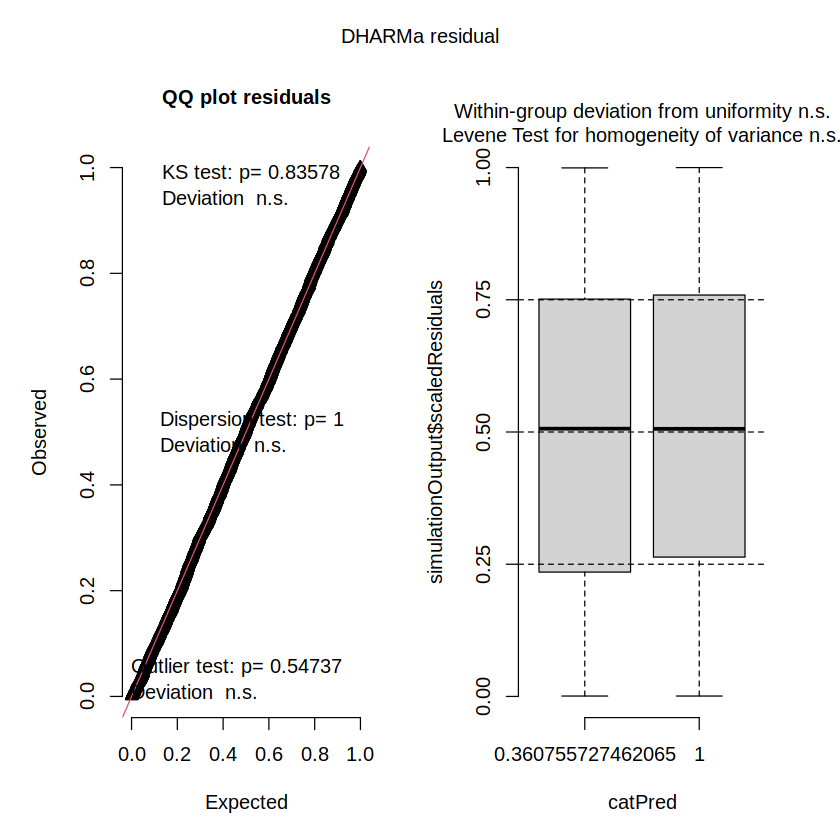

In [21]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

In [22]:
glmm_fit <- glmmTMB(formula=standardized_d~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + (1 | network_id) + (1 | network_size)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1125.3   1176.2   -554.6   1109.3     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 4.654e-12 2.157e-06
 network_size (Intercept) 9.555e-13 9.775e-07
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.66 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -0.04145    0.02081  -1.992   0.0464 *
is_polyploidPolyploids  0.05204    0.03121   1.668   0.0954 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.44    5099.71  -0.005    0.996

In [23]:
glmm_fit_reduced <- glmmTMB(formula=standardized_d~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit_reduced)

 Family: ordbeta  ( logit )
Formula:          standardized_d ~ (1 | network_id) + (1 | network_size)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1126.0   1170.6   -556.0   1112.0     4290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.720e-11 4.148e-06
 network_size (Intercept) 1.552e-14 1.246e-07
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.66 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.01878    0.01576  -1.192    0.233

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.76    5979.12  -0.004    0.997

In [24]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-554.6345,NA,NA,NA
2,7,-556.0244,-1,2.779817,0.09545906


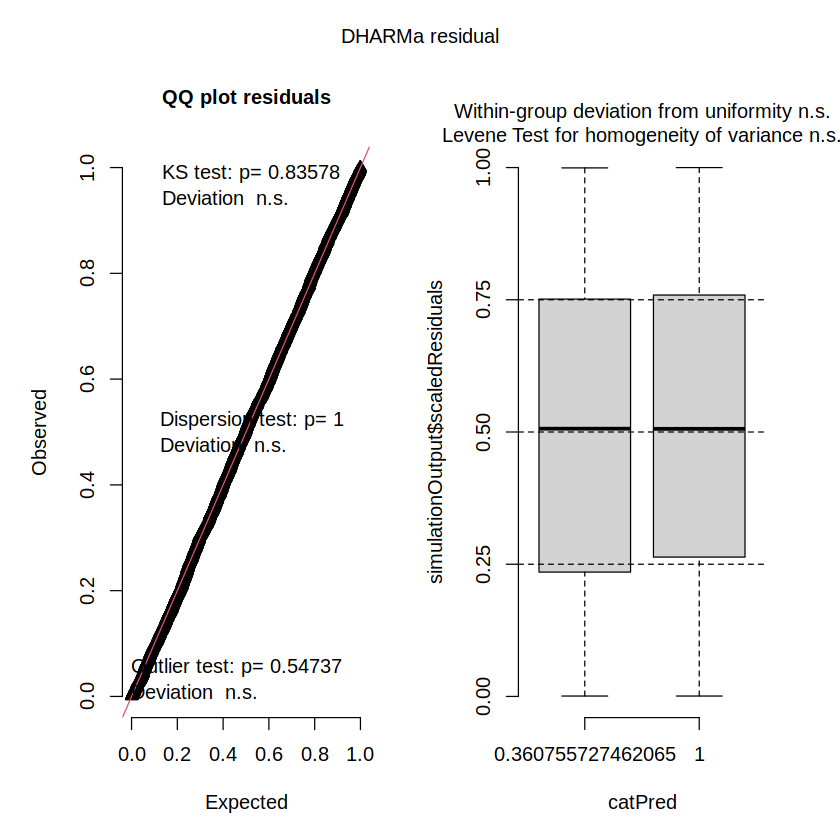

In [25]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

In [26]:
glmm_fit <- glmmTMB(formula=standardized_partner.diversity~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1667.3   1718.2   -825.6   1651.3     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 9.166e-12 3.028e-06
 network_size (Intercept) 8.184e-12 2.861e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family ():  2.9 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)            0.008977   0.020398   0.440   0.6599  
is_polyploidPolyploids 0.056984   0.030425   1.873   0.0611 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.99    6702.13  -0.004    0.997

In [27]:
glmm_fit_reduced <- glmmTMB(formula=standardized_partner.diversity~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit_reduced)

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ (1 | network_id) + (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1668.8   1713.3   -827.4   1654.8     4290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.427e-11 3.777e-06
 network_size (Intercept) 1.785e-10 1.336e-05
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family ():  2.9 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.03375    0.01553   2.172   0.0298 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.69    5784.09  -0.004    0.996

In [28]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-825.6321,NA,NA,NA
2,7,-827.3855,-1,3.5067,0.06112108


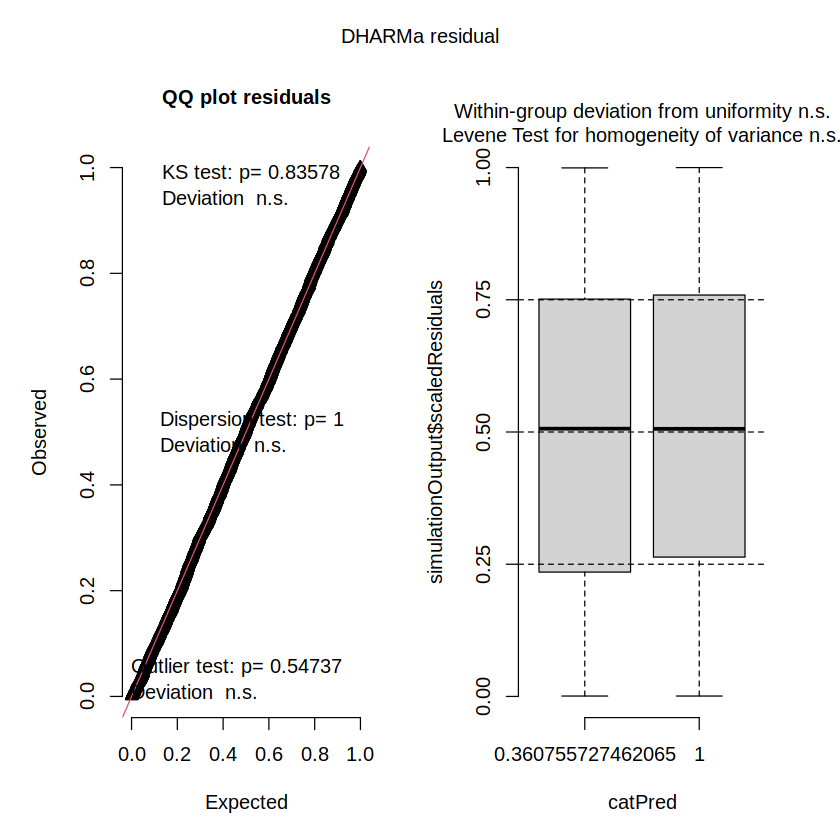

In [29]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

In [30]:
glmm_fit <- glmmTMB(formula=standardized_normalised.degree~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1758.9   1809.8   -871.5   1742.9     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.078e-12 1.038e-06
 network_size (Intercept) 1.338e-11 3.658e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.98 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)            0.006316   0.020238   0.312   0.7550  
is_polyploidPolyploids 0.058590   0.030201   1.940   0.0524 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.77    6021.67  -0.004    0.997

In [31]:
glmm_fit_reduced <- glmmTMB(formula=standardized_normalised.degree~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit_reduced)

 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ (1 | network_id) + (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1760.7   1805.2   -873.3   1746.7     4290 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.955e-11 4.422e-06
 network_size (Intercept) 2.282e-10 1.511e-05
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.98 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.03170    0.01545   2.052   0.0402 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.57    5442.15  -0.005    0.996

In [32]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-871.4531,NA,NA,NA
2,7,-873.3345,-1,3.762732,0.05240687


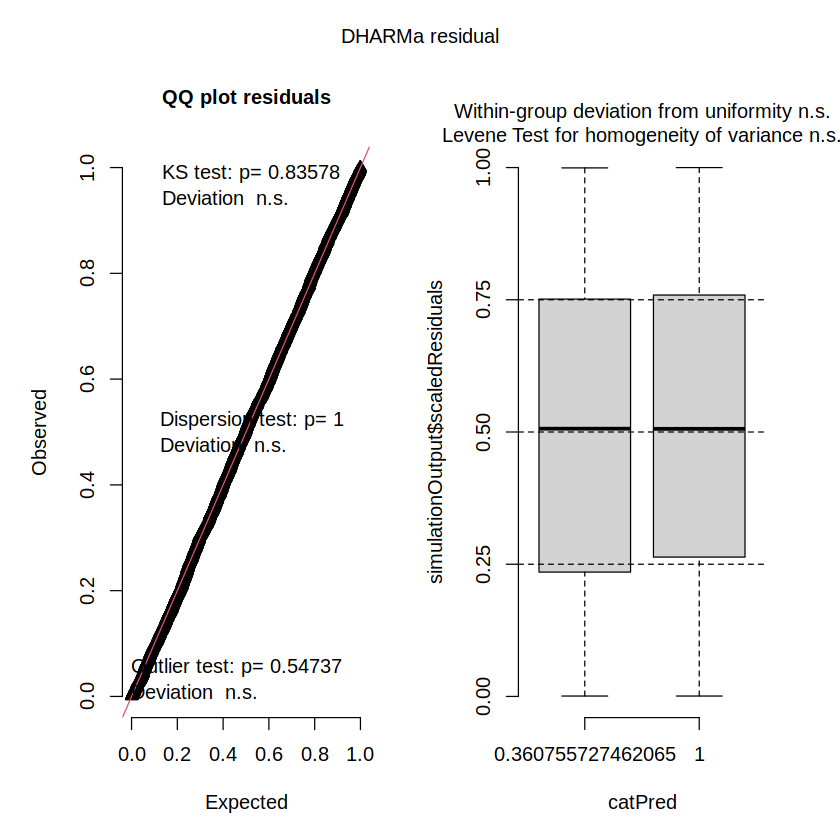

In [34]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

In [35]:
glmm_fit <- glmmTMB(formula=standardized_weighted.betweenness~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1095.5   1146.5   -539.8   1079.5     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.791e-12 1.338e-06
 network_size (Intercept) 1.165e-12 1.080e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 4.17 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.091792   0.017961   5.110 3.21e-07 ***
is_polyploidPolyploids 0.003755   0.027019   0.139    0.889    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.28    4715.54  -0.005    0.996

In [36]:
glmm_fit_reduced <- glmmTMB(formula=standardized_weighted.betweenness~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1095.5   1146.5   -539.8   1079.5     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.791e-12 1.338e-06
 network_size (Intercept) 1.165e-12 1.080e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 4.17 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.091792   0.017961   5.110 3.21e-07 ***
is_polyploidPolyploids 0.003755   0.027019   0.139    0.889    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.28    4715.54  -0.005    0.996

In [37]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-539.7738,NA,NA,NA
2,7,-539.7835,-1,0.01931975,0.8894537


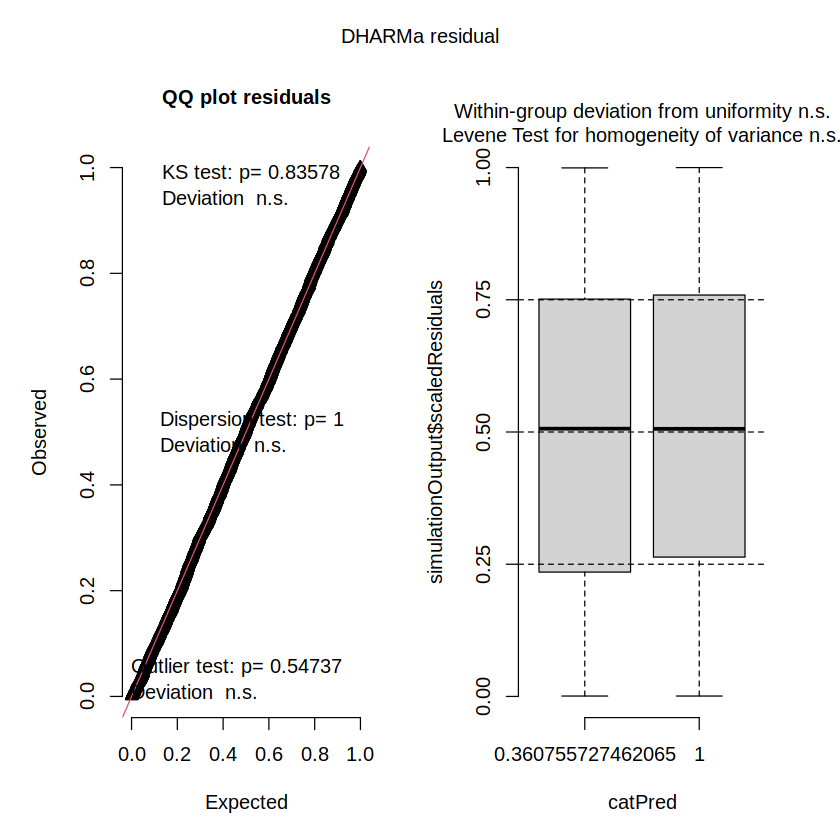

In [38]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

In [39]:
glmm_fit <- glmmTMB(formula=standardized_weighted.closeness~is_polyploid+(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1898.2   1949.2   -941.1   1882.2     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.199e-12 1.095e-06
 network_size (Intercept) 4.848e-12 2.202e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.61 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -0.04120    0.02105  -1.957   0.0503 .
is_polyploidPolyploids  0.02821    0.03143   0.897   0.3696  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.36    8067.88  -0.003    0.997

In [40]:
glmm_fit_reduced <- glmmTMB(formula=standardized_weighted.closeness~(1|network_id)+(1|network_size)
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
summary(glmm_fit)

Warning message in fitTMB(TMBStruc):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”


 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1898.2   1949.2   -941.1   1882.2     4289 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 1.199e-12 1.095e-06
 network_size (Intercept) 4.848e-12 2.202e-06
Number of obs: 4297, groups:  network_id, 514; network_size, 139

Dispersion parameter for ordbeta family (): 2.61 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -0.04120    0.02105  -1.957   0.0503 .
is_polyploidPolyploids  0.02821    0.03143   0.897   0.3696  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.36    8067.88  -0.003    0.997

In [41]:
lrtest(glmm_fit, glmm_fit_reduced)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-941.1219,NA,NA,NA
2,7,NA,-1,NA,NA


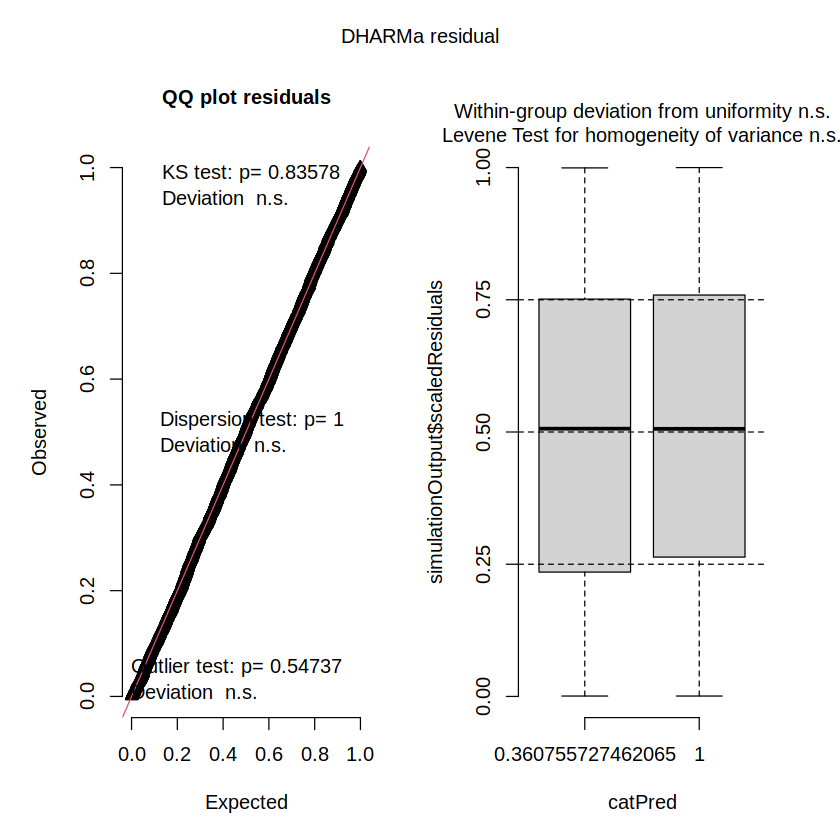

In [42]:
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

# attempt 2: phylogenetic glmm with random effects

In [3]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

In [50]:
data$is_polyploid = factor(data$is_polyploid)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


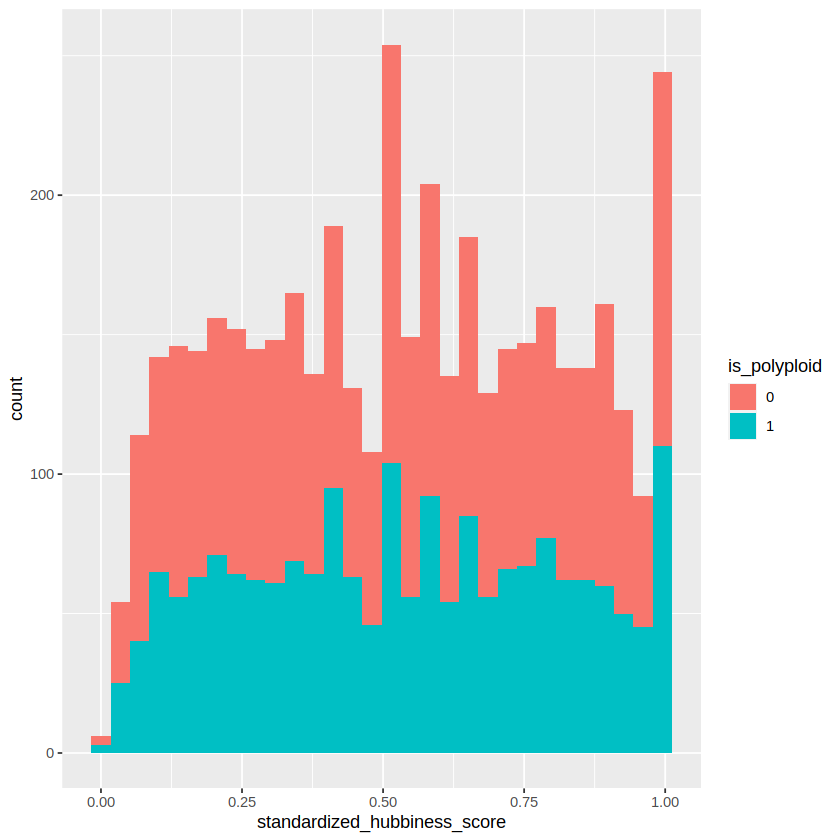

In [51]:
ggplot(data, aes(x = standardized_hubbiness_score, fill = is_polyploid)) + geom_histogram()

In [52]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_hubbiness_score~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_hubbiness_score ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1515.2   1572.6   -748.6   1497.2     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 7.275e-06 2.697e-03
 network_id   (Intercept) 3.689e-11 6.074e-06
 network_size (Intercept) 2.847e-12 1.687e-06
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.79 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.008768   0.026999   0.325    0.745
is_polyploid1 0.028596   0.030868   0.926    0.354

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.27    4654.34  -0.005    0.996

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


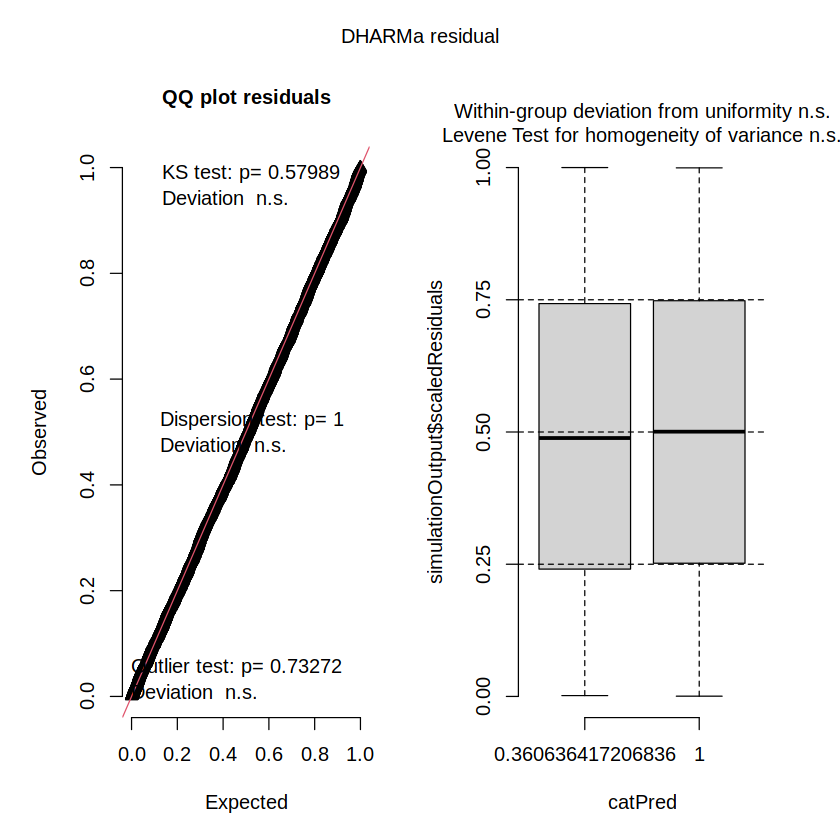

In [53]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


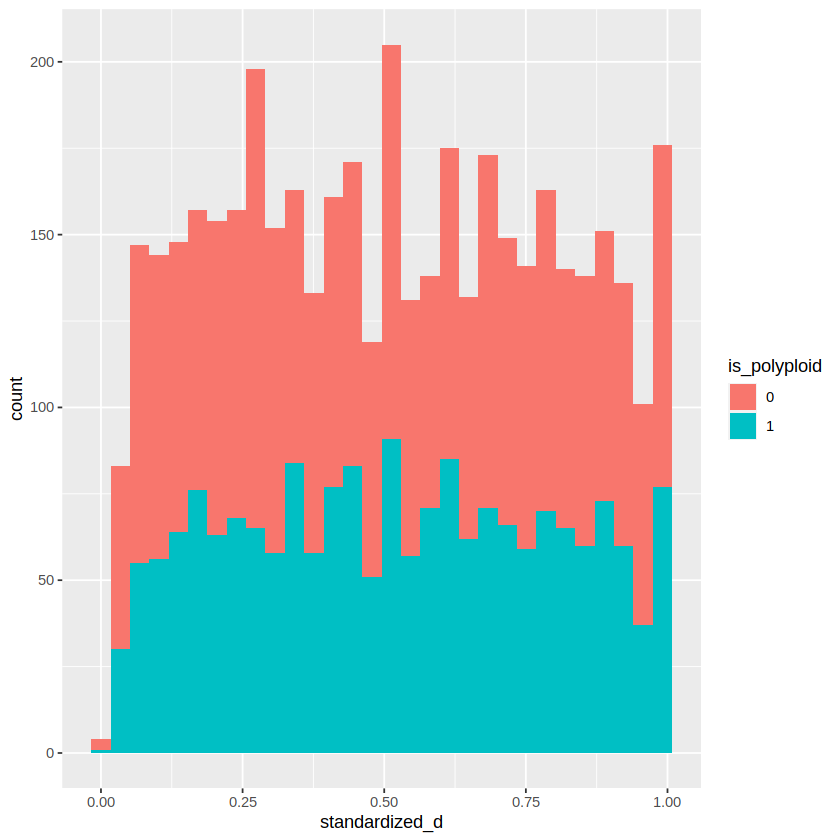

In [54]:
ggplot(data, aes(x = standardized_d, fill = is_polyploid)) + geom_histogram()

In [55]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_d~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + (1 | sample_id) + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1006.2   1063.6   -494.1    988.2     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 1.891e-03 4.349e-02
 network_id   (Intercept) 1.570e-11 3.962e-06
 network_size (Intercept) 1.833e-11 4.282e-06
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.92 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.03525    0.13335   0.264    0.792
is_polyploid1  0.06339    0.03881   1.633    0.102

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -27.1    11632.0  -0.002    0.998

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


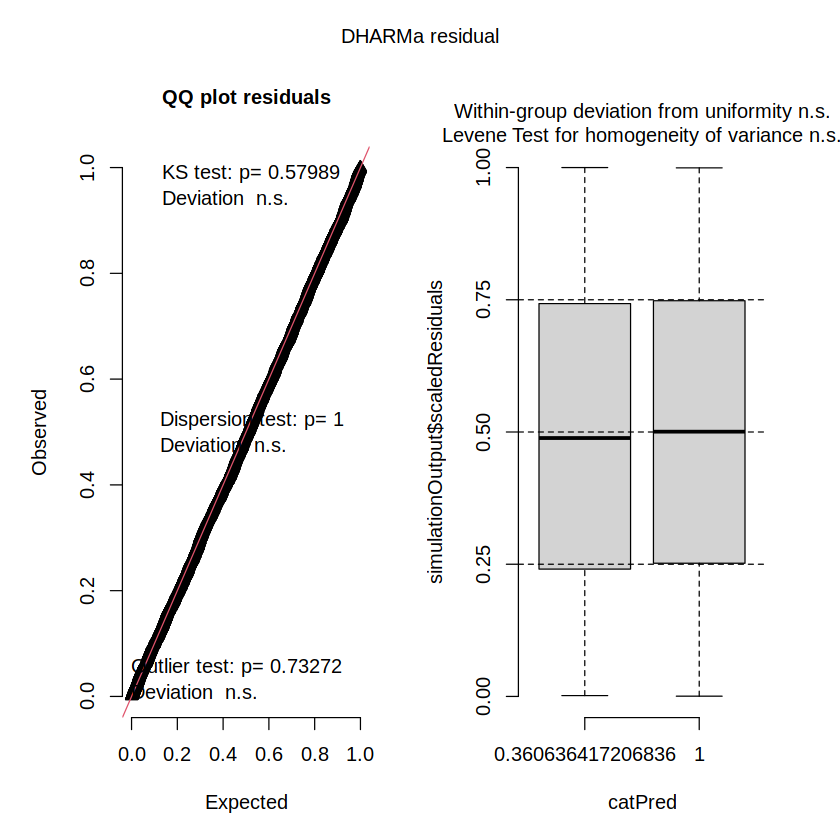

In [56]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


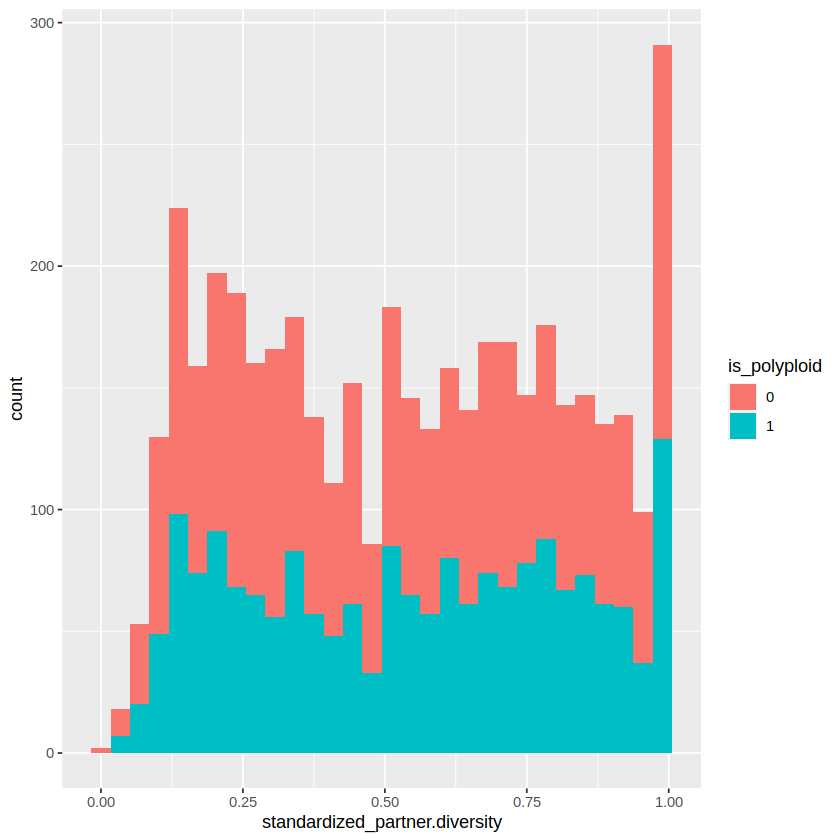

In [57]:
ggplot(data, aes(x = standardized_partner.diversity, fill = is_polyploid)) + geom_histogram()

In [61]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_partner.diversity~is_polyploid+(1|sample_id)+(1|network_id)+(1|network_size)
                                , family=ordbeta(link = "logit")
                                , ziformula=~1
                                , data=data
                                , phylonm = "sample_id"
                                , phylo = tree
                                , control= glmmTMBControl(rank_check = "skip"),
                                )
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1172.8   1230.2   -577.4   1154.8     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 6.119e-03 7.822e-02
 network_id   (Intercept) 3.599e-12 1.897e-06
 network_size (Intercept) 9.922e-11 9.961e-06
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 3.71 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.10087    0.22419  -0.450    0.653
is_polyploid1  0.00841    0.04273   0.197    0.844

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.72    9643.97  -0.003    0.998

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


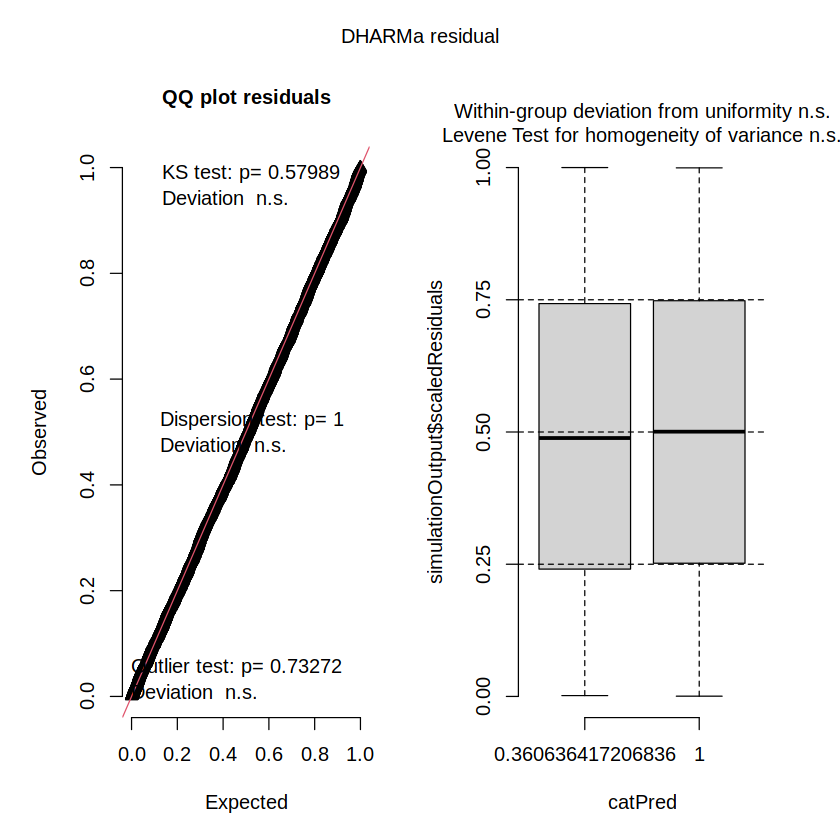

In [62]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


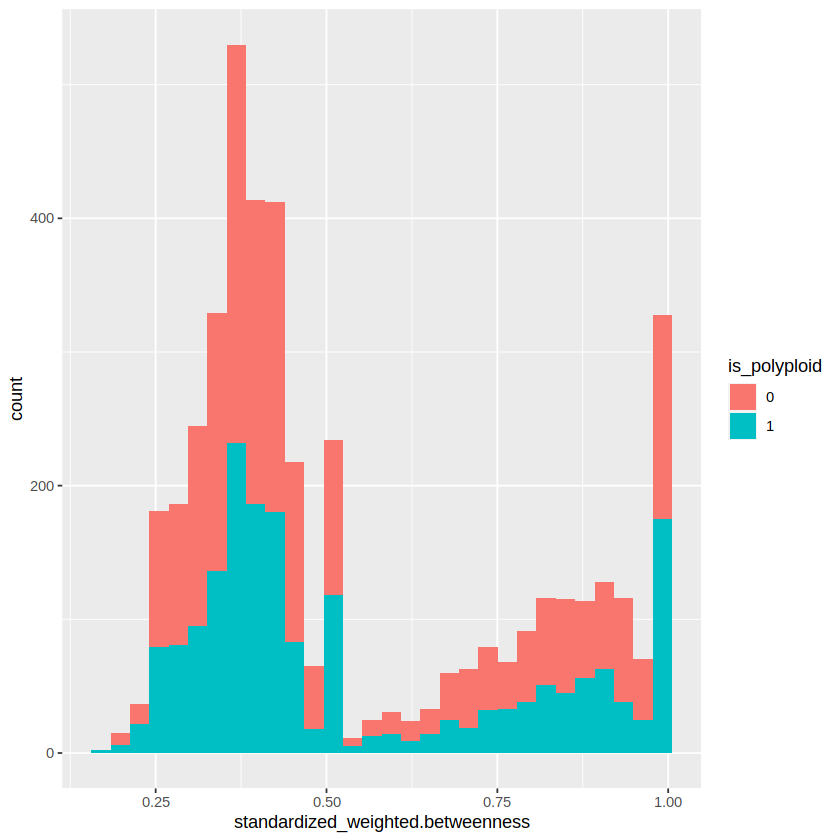

In [63]:
ggplot(data, aes(x=standardized_weighted.betweenness, fill = is_polyploid)) + geom_histogram()

In [64]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_weighted.betweenness~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
   833.6    891.0   -407.8    815.6     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 3.610e-03 6.008e-02
 network_id   (Intercept) 4.371e-12 2.091e-06
 network_size (Intercept) 6.090e-13 7.804e-07
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 4.95 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.02809    0.17444  -0.161    0.872
is_polyploid1 -0.03040    0.03657  -0.831    0.406

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.26    7648.13  -0.003    0.997

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


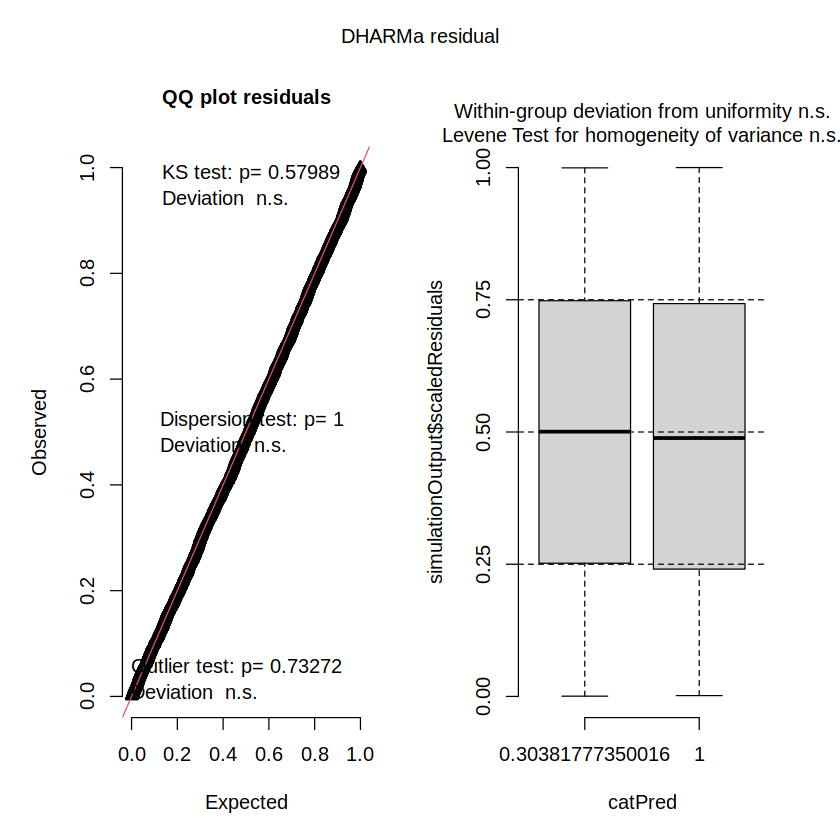

In [65]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


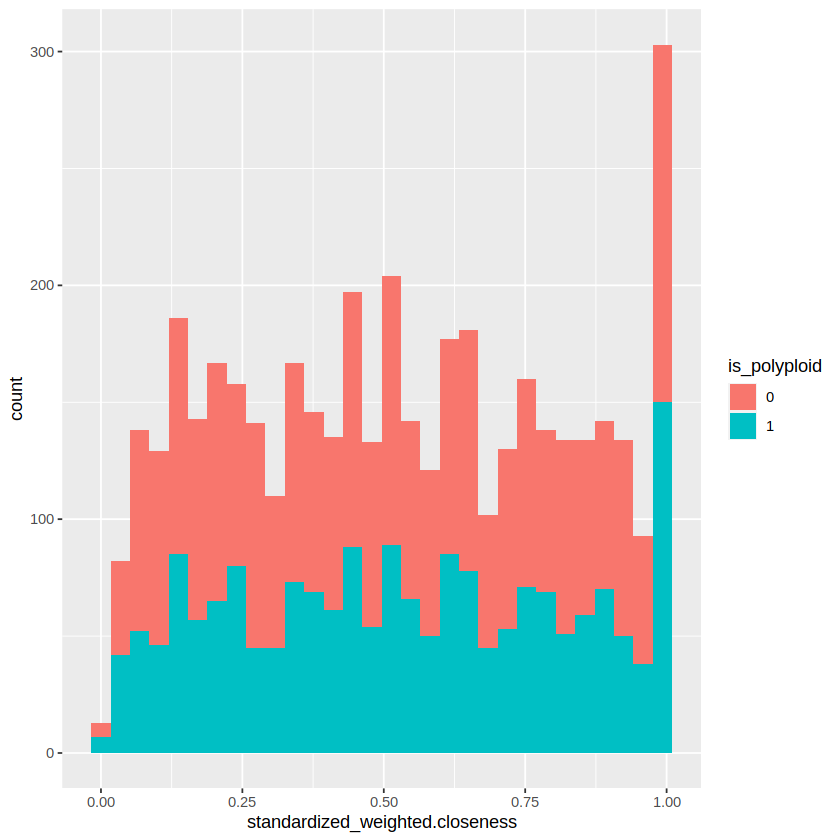

In [66]:
ggplot(data, aes(x=standardized_weighted.closeness, fill = is_polyploid)) + geom_histogram()

In [67]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_weighted.closeness~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"), #lmerControl(check.nobs.vs.nlev="ignore",check.nobs.vs.nRE="ignore")
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1605.6   1663.0   -793.8   1587.6     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 4.256e-03 6.523e-02
 network_id   (Intercept) 6.176e-12 2.485e-06
 network_size (Intercept) 1.055e-11 3.248e-06
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family ():  3.1 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.15783    0.19098  -0.826    0.409
is_polyploid1 -0.02660    0.04225  -0.630    0.529

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.03    6814.71  -0.004    0.997

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


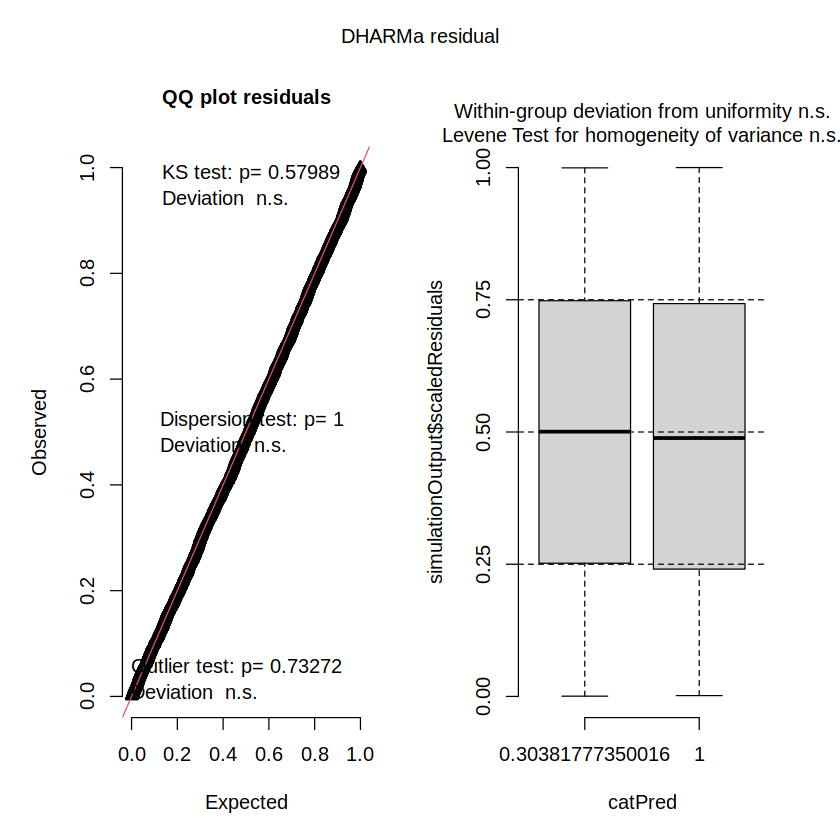

In [68]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


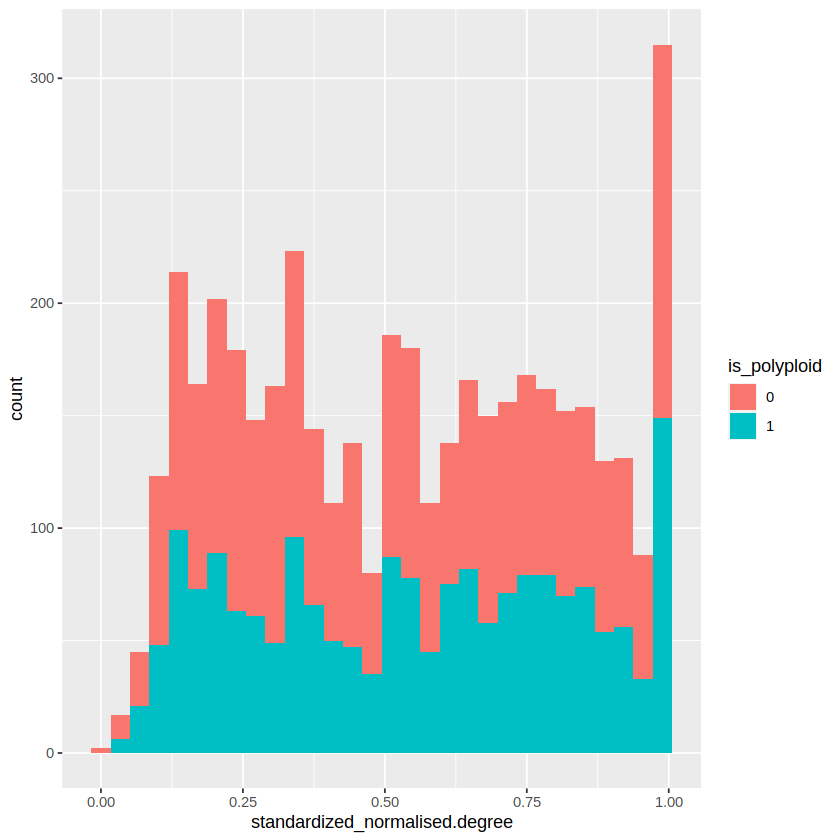

In [69]:
ggplot(data, aes(x=standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()

In [70]:
phylo_lmm_fit_degree <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"), #lmerControl(check.nobs.vs.nlev="ignore",check.nobs.vs.nRE="ignore")
)
summary(phylo_lmm_fit_degree)

 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1232.4   1289.8   -607.2   1214.4     4331 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 7.089e-03 8.420e-02
 network_id   (Intercept) 8.909e-12 2.985e-06
 network_size (Intercept) 6.895e-12 2.626e-06
Number of obs: 4340, groups:  
sample_id, 4340; network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 3.85 

Conditional model:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.103115   0.239699  -0.430    0.667
is_polyploid1  0.005498   0.043331   0.127    0.899

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.74    5886.69  -0.004    0.997

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


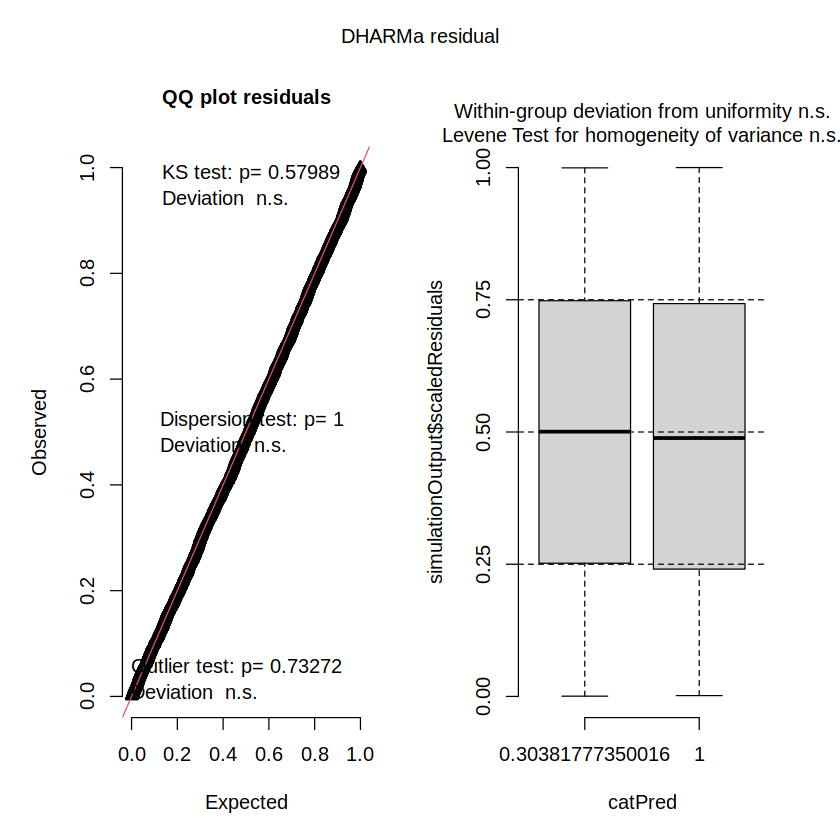

In [71]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

# perform test on poly-diplo pairs

In [31]:
mixed = glmmTMB(formula=standardized_d_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_d_diff ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -628.2   -596.5    320.1   -640.2     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.01158  0.1076  
 phylogenetic_dist (Intercept) 0.01132  0.1064  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 4.59 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.78608    0.03758 -20.915   <2e-16 ***
pair_typepd  0.01214    0.04882   0.249    0.804    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1744     0.2148  -19.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05

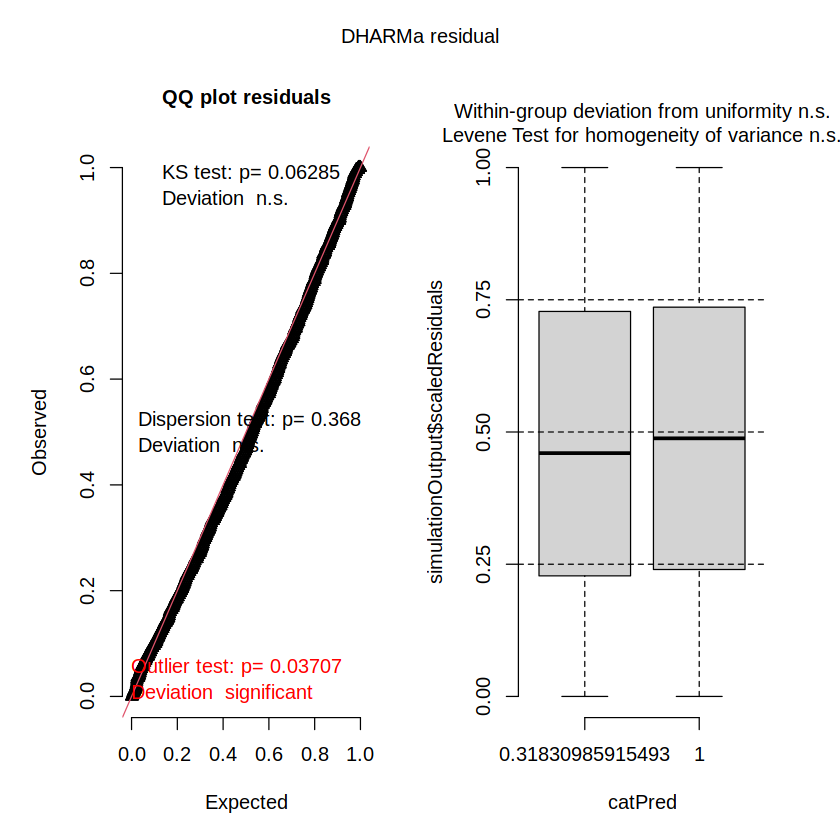

In [32]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


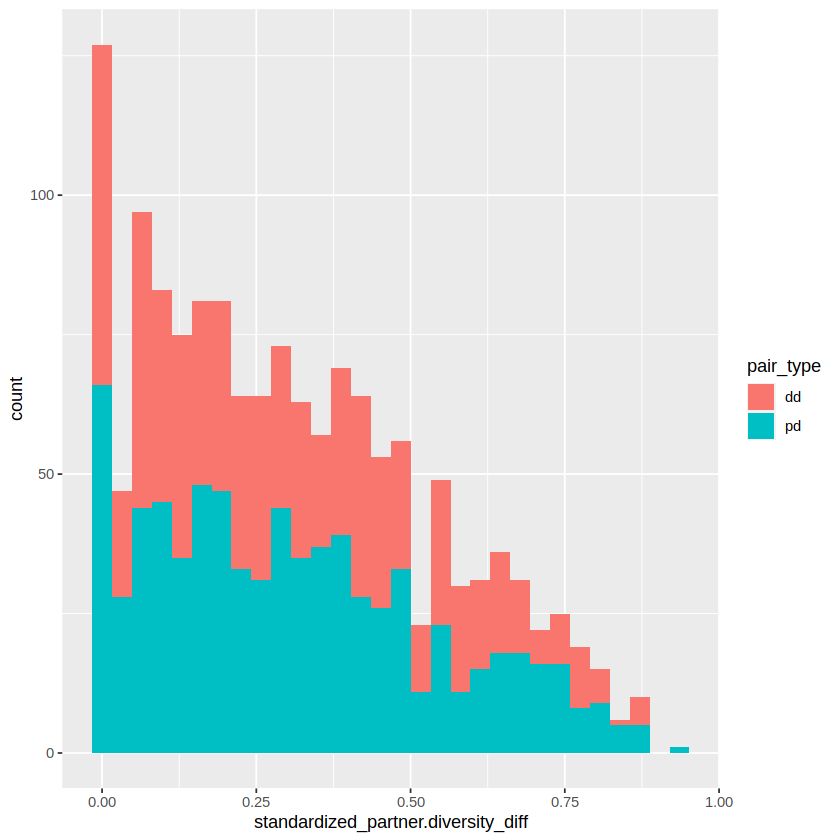

In [33]:
ggplot(pair_data, aes(x=standardized_partner.diversity_diff, fill = pair_type)) + geom_histogram()

In [34]:
mixed = glmmTMB(formula=standardized_partner.diversity_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_partner.diversity_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   134.9    166.6    -61.5    122.9     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05653  0.2378  
 phylogenetic_dist (Intercept) 0.07794  0.2792  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 4.86 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.65107    0.04656 -13.985   <2e-16 ***
pair_typepd  0.01039    0.05698   0.182    0.855    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.43451    0.09642  -25.25   <2e-16 ***
---
Signif. co

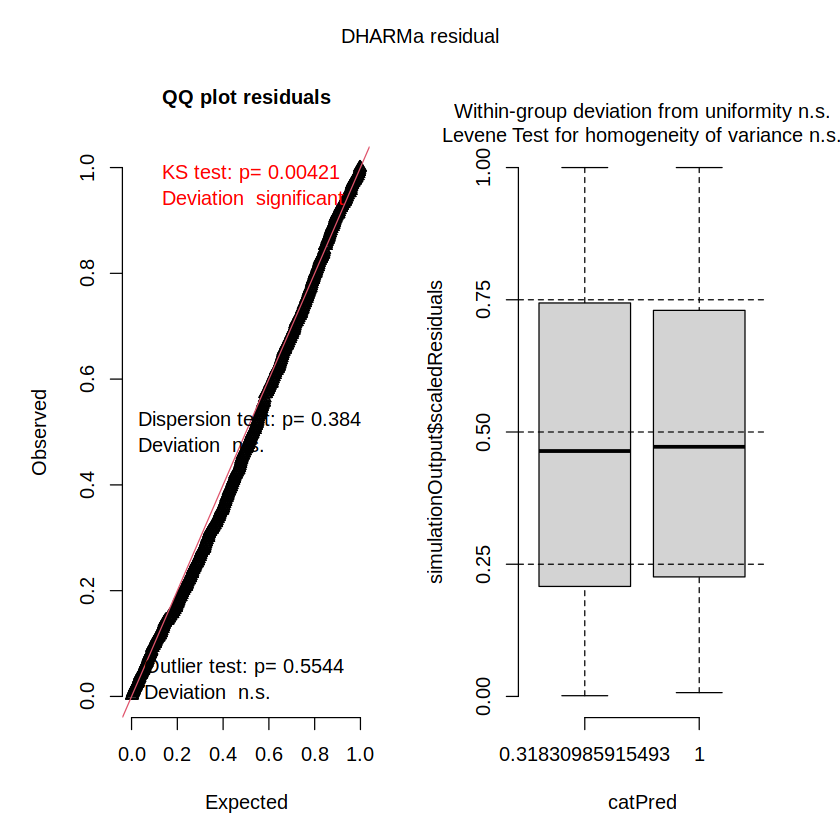

In [35]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


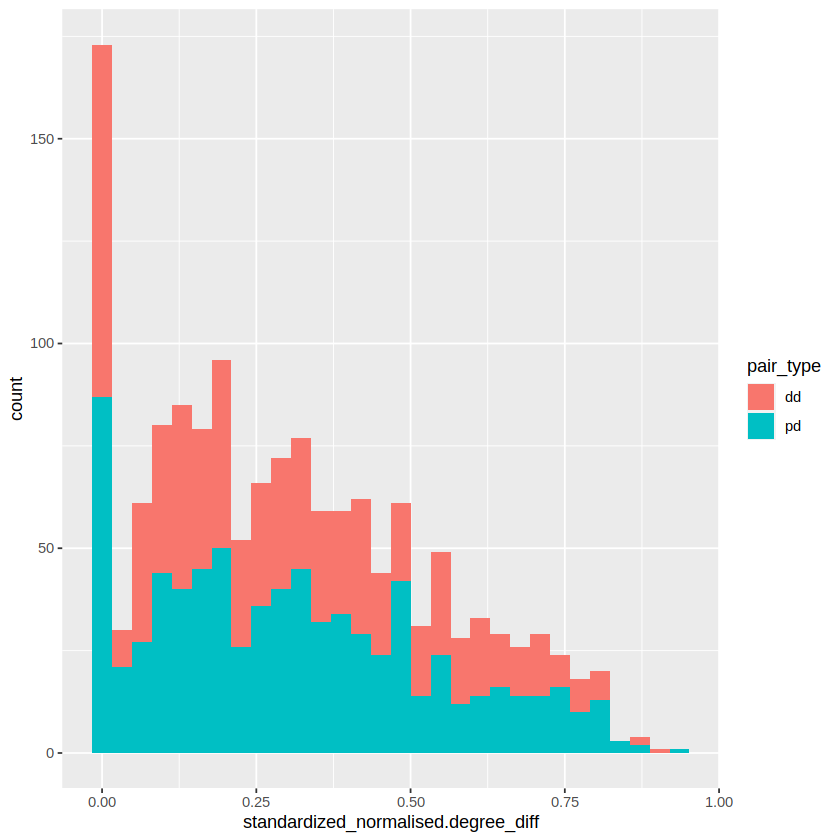

In [36]:
ggplot(pair_data, aes(x=standardized_normalised.degree_diff, fill = pair_type)) + geom_histogram()

In [37]:
mixed = glmmTMB(formula=standardized_normalised.degree_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_normalised.degree_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   370.6    402.3   -179.3    358.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05961  0.2441  
 phylogenetic_dist (Intercept) 0.06366  0.2523  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.47 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.60420    0.04542 -13.303   <2e-16 ***
pair_typepd  0.02585    0.05492   0.471    0.638    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.00054    0.08101   -24.7   <2e-16 ***
---
Signif. co

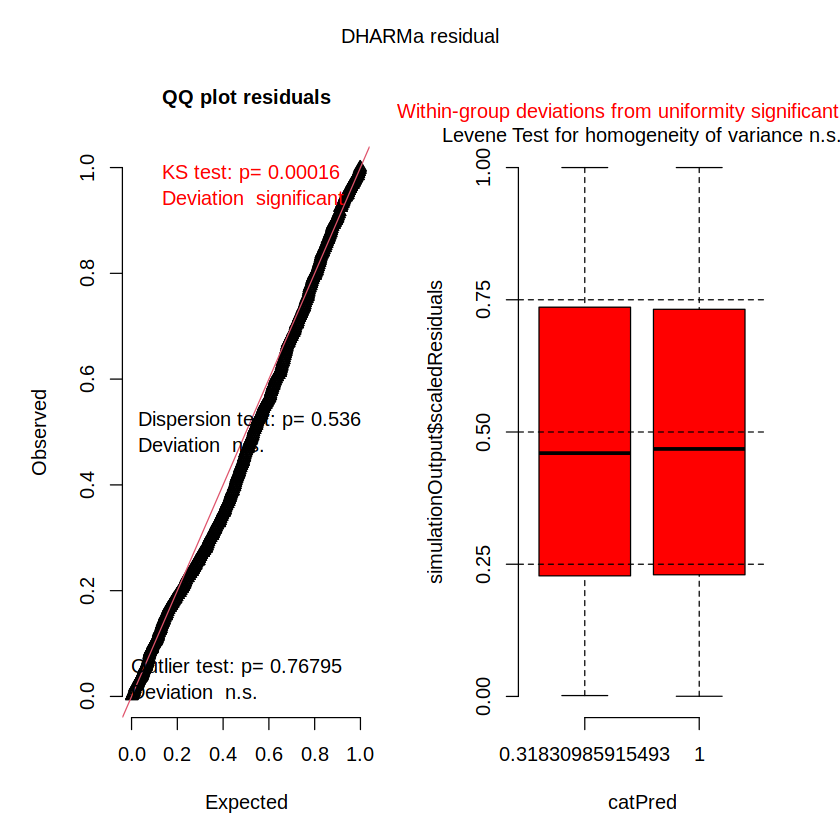

In [38]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


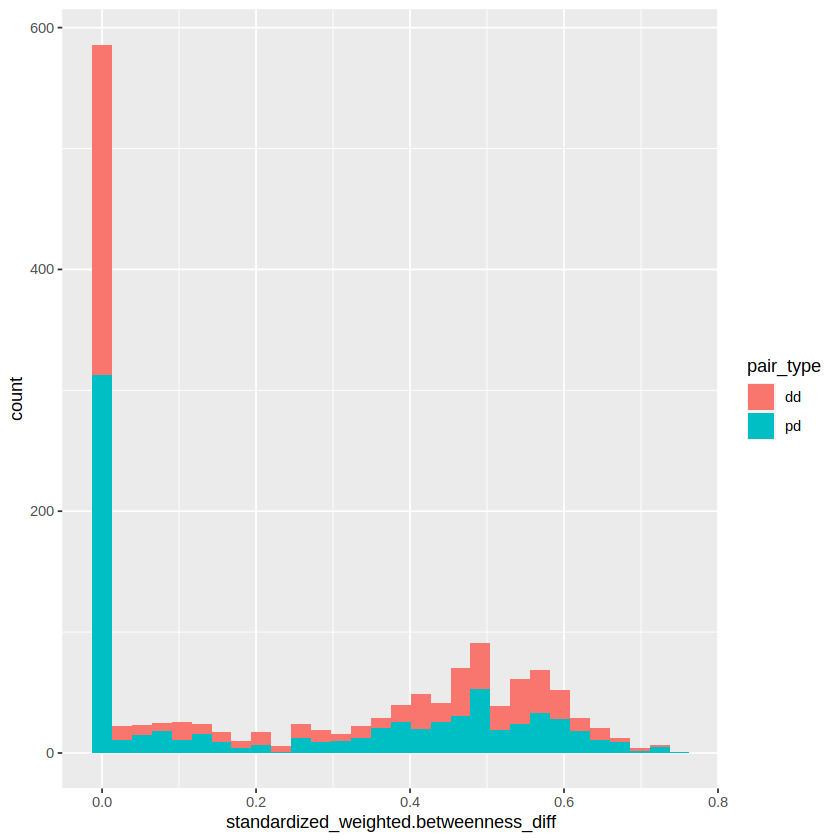

In [39]:
ggplot(pair_data, aes(x=standardized_weighted.betweenness_diff, fill = pair_type)) + geom_histogram()

In [40]:
mixed = glmmTMB(formula=standardized_weighted.betweenness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.betweenness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                          ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  1462.3   1493.9   -725.1   1450.3     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.04021  0.2005  
 phylogenetic_dist (Intercept) 0.15977  0.3997  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  7.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.37683    0.05347  -7.047 1.83e-12 ***
pair_typepd -0.01805    0.06744  -0.268    0.789    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.40776    0.05358   -7.61 2.74e-14 ***
---
Sign

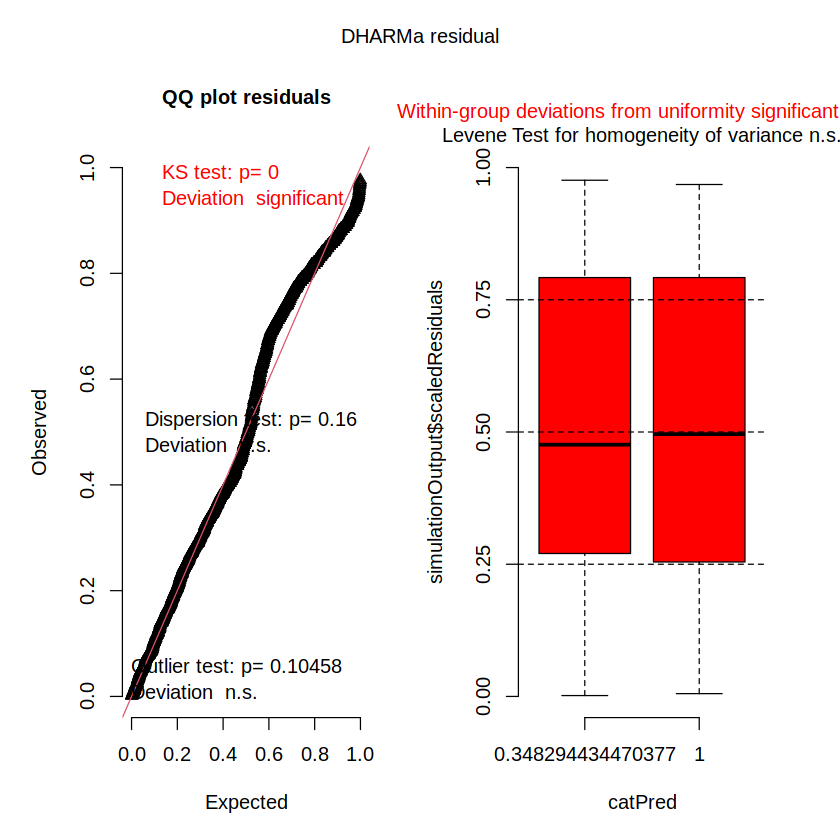

In [41]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


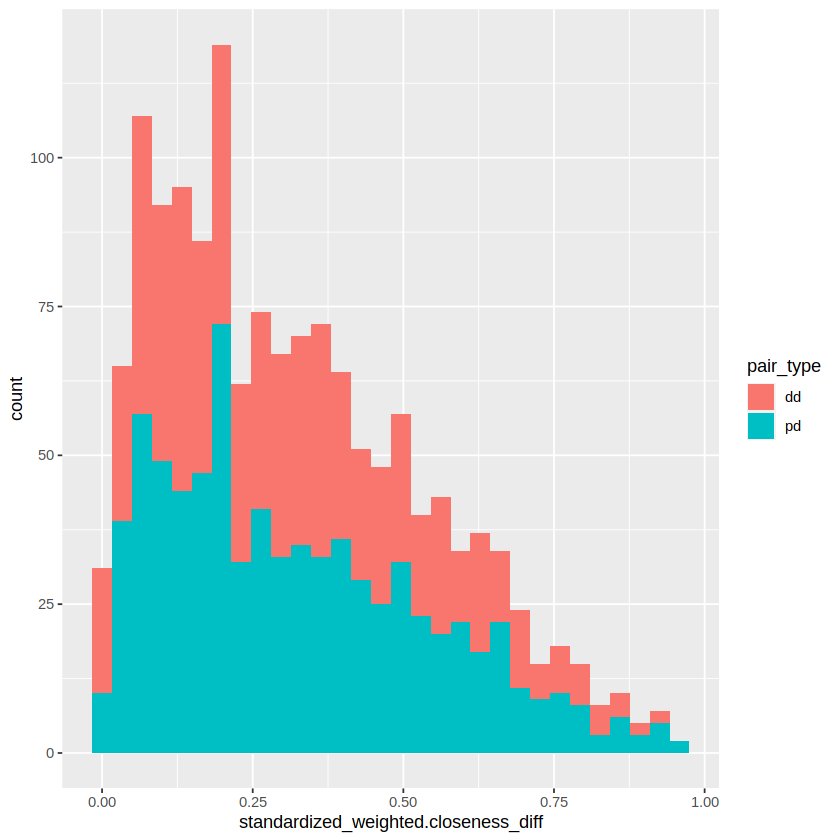

In [42]:
ggplot(pair_data, aes(x=standardized_weighted.closeness_diff, fill = pair_type)) + geom_histogram()

In [43]:
mixed = glmmTMB(formula=standardized_weighted.closeness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.closeness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                        ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -490.6   -458.9    251.3   -502.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.01343  0.1159  
 phylogenetic_dist (Intercept) 0.09186  0.3031  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  4.5 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.74985    0.04340 -17.279   <2e-16 ***
pair_typepd  0.03649    0.05626   0.649    0.517    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1292     0.2102  -19.65   <2e-16 ***
---
Signif. 

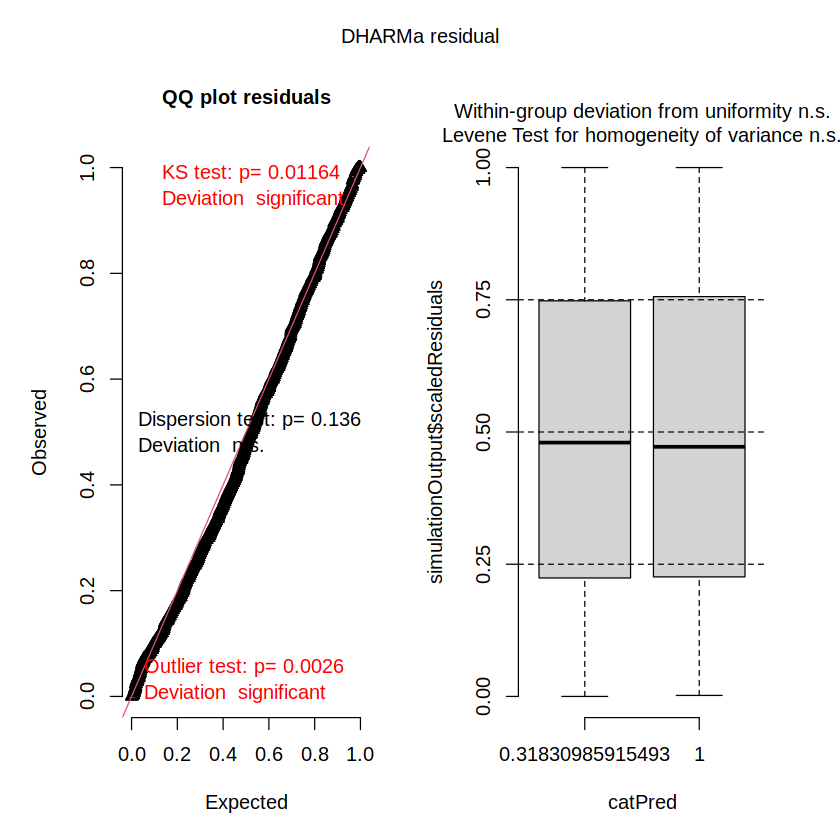

In [44]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


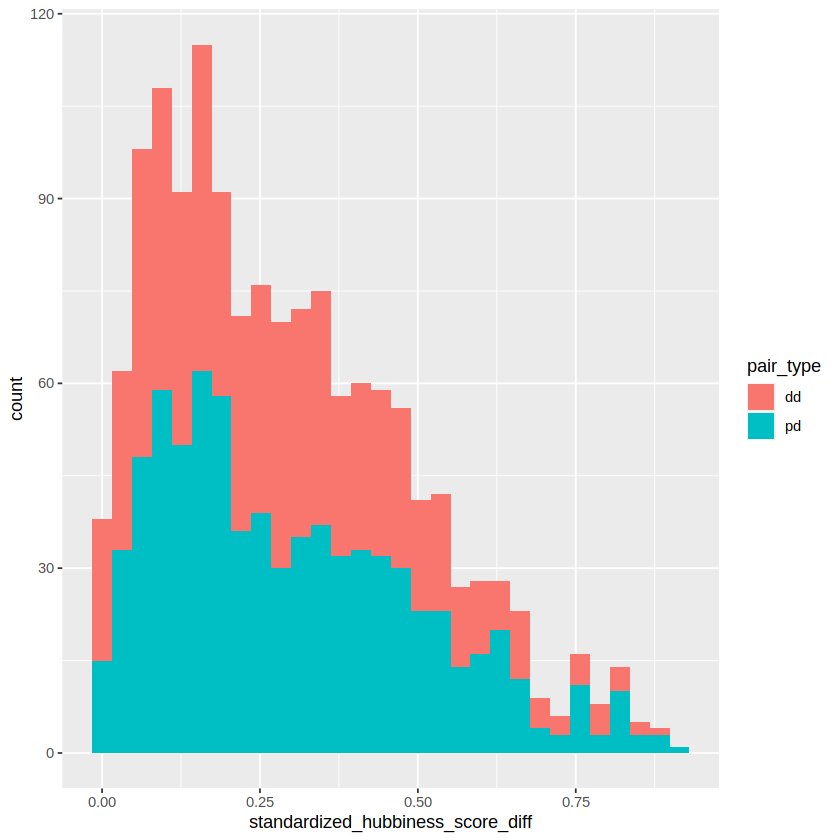

In [45]:
ggplot(pair_data, aes(x=standardized_hubbiness_score_diff, fill = pair_type)) + geom_histogram()


In [46]:
mixed = glmmTMB(formula=standardized_hubbiness_score_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_hubbiness_score_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                     ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -661.7   -630.0    336.9   -673.7     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.02040  0.1428  
 phylogenetic_dist (Intercept) 0.06243  0.2499  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.17 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.88265    0.04149 -21.272   <2e-16 ***
pair_typepd  0.06837    0.05284   1.294    0.196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.8586     0.1845  -20.91   <2e-16 ***
---
Signif. codes:

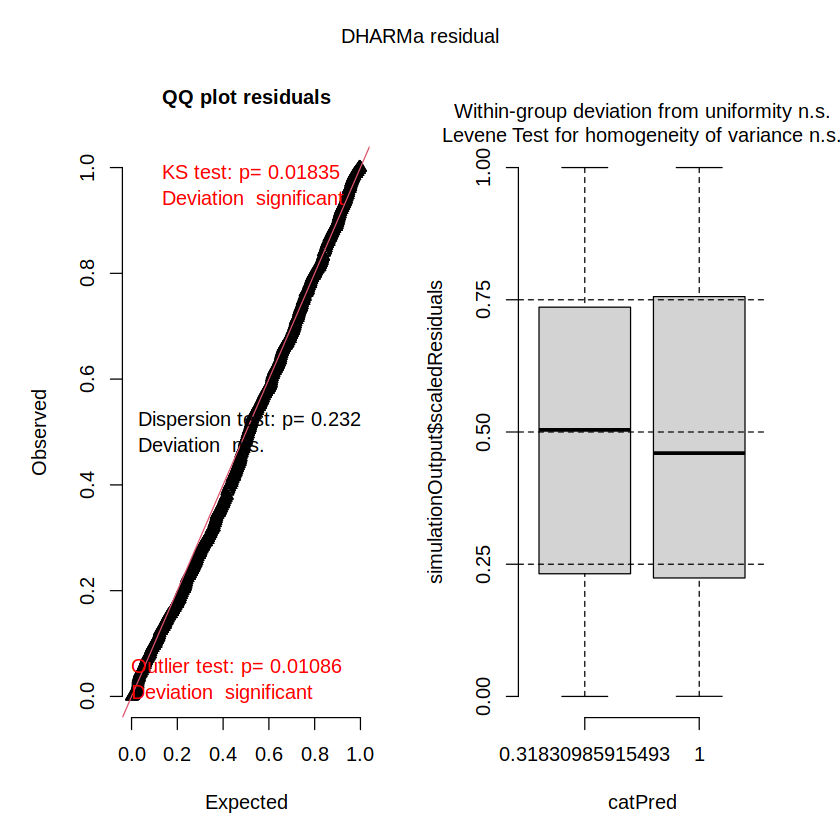

In [47]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

# compute niche overlap across pairs

In [24]:
get_niche_overlap <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = as.matrix(vegdist(network, method="horn"))
    if (!((member1 %in% rownames(res) && (member2 %in% rownames(res)))))
        {
        return(NA)
        }
    return(res[c(member1),c(member2)])  
    }

In [25]:
if (!("horn_index" %in% colnames(pair_data)))
{
    pair_data["horn_index"] = pbmcmapply(get_niche_overlap, 
                                         pair_data$network_path, 
                                         pair_data$member1, 
                                         pair_data$member2,
                                         ignore.interactive = getOption("ignore.interactive", T),
                                         mc.cores = 10)
    write.csv(pair_data, pair_data_path)
}

  |=======================================================| 100%, Elapsed 02:22


In [ ]:
ggplot(pair_data, aes(x=horn_index, fill = pair_type)) + geom_histogram()

In [27]:
mixed = glmmTMB(formula=horn_index~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=pair_data[!is.na(pair_data$horn_index), ]
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
print(summary(mixed))

 Family: ordbeta  ( logit )
Formula:          
horn_index ~ pair_type + (1 | pair) + (1 | network_id) + (1 |  
    phylogenetic_dist)
Data: pair_data[!is.na(pair_data$horn_index), ]

     AIC      BIC   logLik deviance df.resid 
   982.0   1022.5   -483.0    966.0     1152 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 pair              (Intercept) 0.03661  0.1913  
 network_id        (Intercept) 0.32933  0.5739  
 phylogenetic_dist (Intercept) 0.16883  0.4109  
Number of obs: 1160, groups:  
pair, 644; network_id, 227; phylogenetic_dist, 531

Dispersion parameter for ordbeta family (): 9.91 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.81743    0.07164  11.411   <2e-16 ***
pair_typepd  0.07699    0.07124   1.081     0.28    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


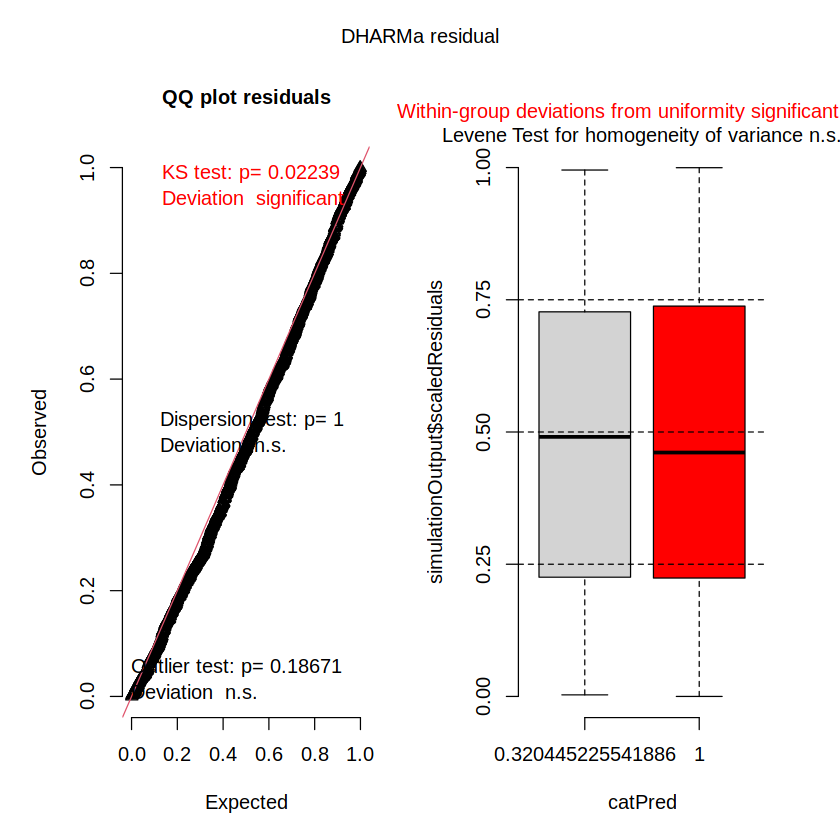

In [28]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

# compute module sharing between pairs

In [29]:
get_module_sharing <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = computeModules(network)
    modules_matrix = as.matrix(slot(res, "modules"))
    if (!((member1 %in% rownames(network) && (member2 %in% rownames(network)))))
        {
        return(NA)
        }
    m1_modules = modules_matrix[, which(member1 == rownames(network))+2] > 0
    m2_modules = modules_matrix[, which(member2 == rownames(network))+2] > 0
    frac_shared_modules = sum(m1_modules&m2_modules) / ncol(modules_matrix)
    return(frac_shared_modules)
    }

In [30]:
if (!("frac_shared_modules" %in% colnames(pair_data)))
{
pair_data["frac_shared_modules"] = pbmcmapply(get_module_sharing, 
                                     pair_data$network_path, 
                                     pair_data$member1, 
                                     pair_data$member2,
                                     ignore.interactive = getOption("ignore.interactive", T),
                                     mc.cores = 40)
    write.csv(pair_data, pair_data_path)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


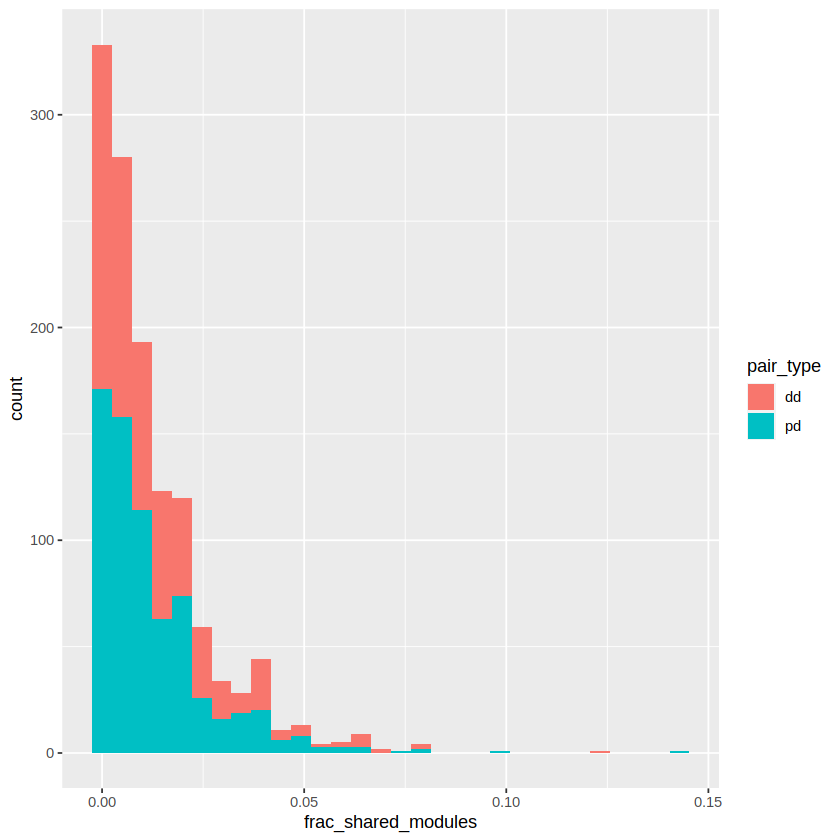

In [31]:
ggplot(pair_data, aes(x=frac_shared_modules, fill = pair_type)) + geom_histogram()

In [32]:
# error https://github.com/glmmTMB/glmmTMB/issues/744
mixed = glmmTMB(formula=frac_shared_modules~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=ordbeta(link = "logit")
                , ziformula=~0
                , data=pair_data[!is.na(pair_data$horn_index), ]
                , control= glmmTMBControl(rank_check = "skip")
                , start = list(psi = c(-1, 1))
                )
print(summary(mixed))

 Family: ordbeta  ( logit )
Formula:          
frac_shared_modules ~ pair_type + (1 | pair) + (1 | network_id) +  
    (1 | phylogenetic_dist)
Data: pair_data[!is.na(pair_data$horn_index), ]

     AIC      BIC   logLik deviance df.resid 
 -7785.2  -7745.9   3900.6  -7801.2      998 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 pair              (Intercept) 0.01261  0.1123  
 network_id        (Intercept) 0.58280  0.7634  
 phylogenetic_dist (Intercept) 0.01412  0.1188  
Number of obs: 1006, groups:  
pair, 561; network_id, 209; phylogenetic_dist, 466

Dispersion parameter for ordbeta family ():  993 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.95551    0.05734  -68.98   <2e-16 ***
pair_typepd -0.01266    0.02967   -0.43     0.67    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


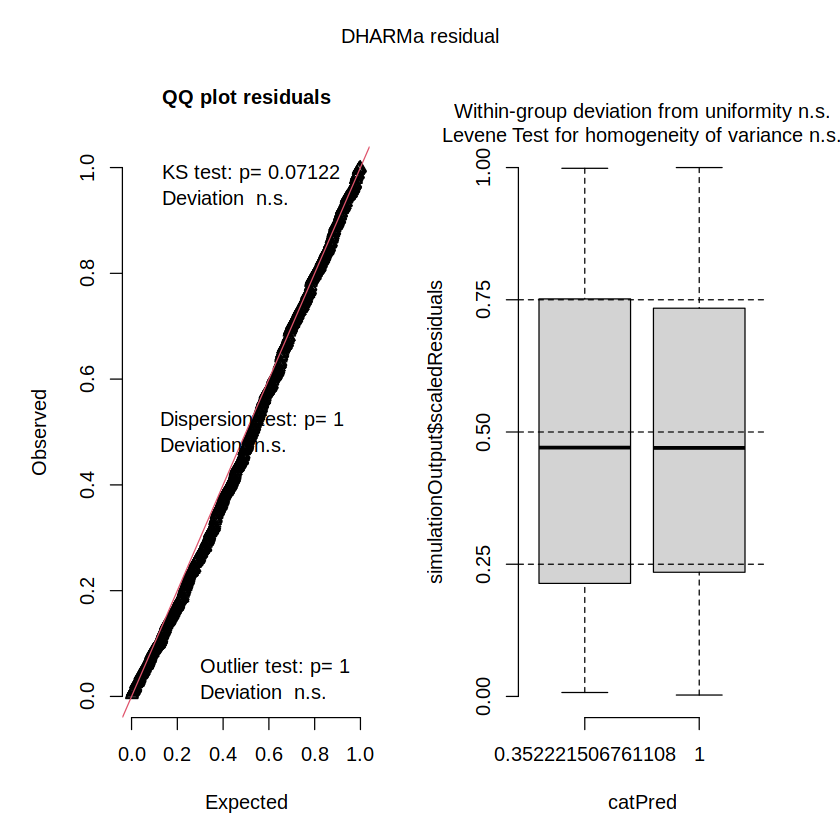

In [33]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)